## Gradients

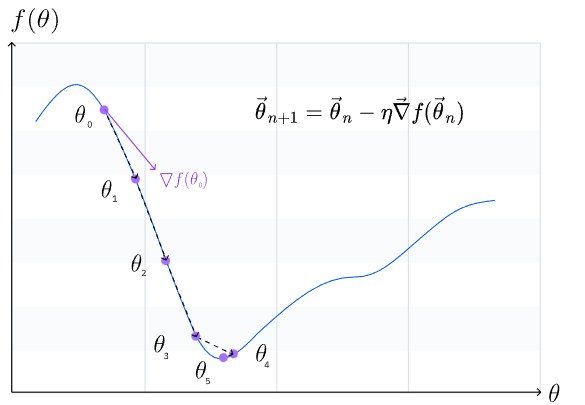

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

First, we define our parametrized state $\ket{\Psi (\vec{\theta})} = U(\vec{\theta}) \ket{00...0}$. Where $U(\vec{\theta})$ is the Qiskit [RealAmplitude](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) circuit on two qubits

In [15]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.opflow import Z, I, StateFn, PauliExpectation, CircuitSampler, Gradient
from qiskit.utils import QuantumInstance
from qiskit import Aer
import numpy as np

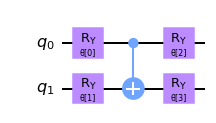

In [3]:
ansatz = RealAmplitudes(num_qubits = 2, reps = 1, entanglement = 'linear').decompose()
ansatz.draw(output='mpl')

Now we define the hamiltonian $\hat{H} = \hat{Z} \otimes \hat{Z}$

In [5]:
hamiltonian = Z ^ Z

Now we compute the expecation value

In [7]:
expectation = StateFn(hamiltonian, is_measurement = True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

Next, we write a function to simulate the measurement of the expectation value

In [9]:
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                  # set a seed for reproducibility
                                  shots = 8192, seed_simulator = 2718,
                                  seed_transpiler = 2718)

sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(pauli_basis, params = value_dict).eval()
    return np.real(result)

Now, what's the derivative of the expectation value with respect to parameter $\theta_{i}$ at point $\vec{p}$?

$$ \frac{\partial}{\partial \theta_{i}} = \bra{ \Psi (\vec{\theta}) } \hat{H} \ket{\Psi (\vec{\theta})} \Big|_{\vec{\theta} = \vec{p}} $$

With a random point $\vec{p}$ and an index $i = 2$ we have

In [13]:
point = np.random.random(ansatz.num_parameters)
INDEX = 2

## Finite difference gradients

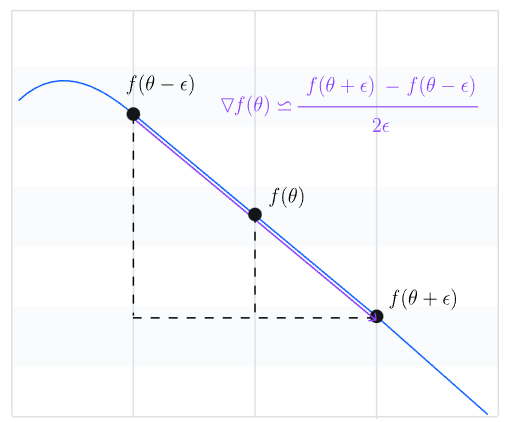

If we are interested in finding the gradient of $f(\vec{\theta})$, we can choose some small distance $\epsilon$ and calculate $f(\vec{\theta} + \epsilon)$ and $f(\vec{\theta} - \epsilon)$ and take the difference, divided by the distance we obtain

$$ \vec{\nabla} f(\vec{\theta}) \approx \frac{1}{2\epsilon} \left( f(\vec{\theta} + \epsilon) - f(\vec{\theta} - \epsilon) \right) $$

In [14]:
EPS = 0.2
# make identity vector with a 1 at index, otherwise 0
e_i = np.identity(point.size)[:, INDEX]

plus  = point + EPS*e_i
minus = point - EPS*e_i

finite_difference = ( (evaluate_expectation(plus) - evaluate_expectation(minus))/(2*EPS) )
print(finite_difference)

0.18981933593750014


Or we can use the Qiskit's [Gradient class](https://qiskit.org/documentation/stubs/qiskit.opflow.gradients.Gradient.html)

In [17]:
shifter = Gradient('fin_diff', analytic = False, epsilon = EPS)
grad    = shifter.convert(expectation, params = ansatz.parameters[INDEX])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


0.1470947265624999

This method it's a little noisy

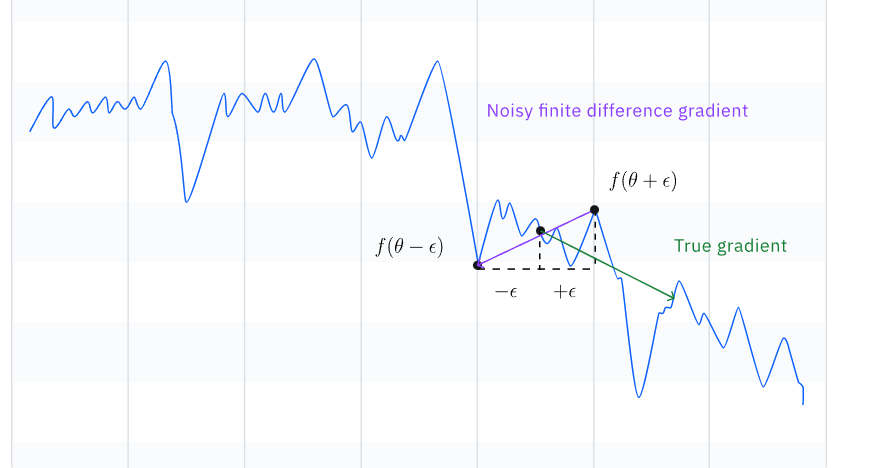